In [1]:
import os
os.chdir('E:\workfile')
import shap

D:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import warnings
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

import model_tools.pipeline as pipeline
from model_tools.Feature_Engineer import groupby_stat, combinations, time_relation
#from model_tools.Model import LGBMClassifier
from model_tools.Preprocessing import encoders
from model_tools.Model import LGBMClassifier, XgbtrainClassifier
from model_tools.data import DataHelper
from model_tools.FeatureSelector import feature_selector
from model_tools import metrics
from model_tools.utils import *
import gc
from imp import reload
reload(encoders)

<module 'model_tools.Preprocessing.encoders' from 'E:\\workfile\\model_tools\\Preprocessing\\encoders.py'>

In [3]:
with timer('prepare dataset'):
    datahper = DataHelper(target='', train_path='./model_tools/Example/model_data.pkl', test_path=None,
                          date_cols='loan_time')
    
    train, _ = datahper.load_data()
    train = time_relation.GentimerelatedFeaures('loan_time', cycle=True, drop=True).fit_transform(train)
    test = train[train['loan_time_month'].isin([11, 12])].reset_index(drop=True)
    train = train[train['loan_time_month'].isin([9, 10])].reset_index(drop=True)

    datahper = DataHelper(target='fspd30_recalled', train_path=None, test_path=None, trainfile=train, testfile=test,
                          date_cols=['apply_time', 'query_time'])
    
    data = datahper.combine()
    cat_vars = datahper.object_features
    date_vars = datahper.date_cols
    target = datahper.target

with timer('pipeline process'):

    """
    data['age'] = data['dm_birthday'].apply(get_age)
    data['birth_month'] = data['dm_birthday'].apply(get_month)
    """
    # data['province'] = data['dm_address'].apply(lambda x: str(x)[:2])
    # data['payment_ratio'] = data['down_payment'] / data['contract_amount']
    gbp_params = {'dm_birthday': {'contract_amount': ['mean', 'var']},
                  'dm_birthday#1': {'down_payment': ['mean', 'var']},
                  'dm_residencetype': {'contract_amount': 'mean'},
                  'dm_occupation': {'contract_amount': ['mean', 'var']},
                  'dm_occupation#1': {'down_payment': ['mean', 'var']},}
                  
    drop_columns = ['dm_name', 'dm_address', 'dm_mobile', 'agreement_id', 'fspd30', 'Unnamed: 52',
                    'event_id', 'uuid', 'dm_unit', 'dm_hometelephoneno', 'dm_reportsn']      
      
    pipe = Pipeline([('CatgoryEncoder', encoders.CategoryEncoder(cat_vars)),
                     # ('CountEncoder', encoders.CountEncoder(['dm_birthday', 'dm_residencetype', 'dm_occupation'])),
                     # ('PercentileEncoder', encoders.PercentileEncoder(input_cols=['call_cnt', 'call_len'])),
                     # ('GroupbyStatic', groupby_stat.GroupbyStaticMethod(gbp_params)),
                     ('ProcTime', time_relation.GentimerelatedFeaures(date_vars, cycle=True)),
                     ('DeleteColumns', pipeline.ColumnDroper(drop_columns)),
                     ('DropConstant', pipeline.Dropconstant())
                     ])
    
    data = pipe.fit_transform(data)

with timer('split data'):
    train, test = datahper.split(data)
    predictors = [x for x in train.columns if x != target]
    # sample = train.sample(50000, random_state=512).reset_index(drop=True)
    # selector = GreedyFeaturesSelector.GreedyFeatureSelection(target)
    # selector.fit(sample)
    # sel_cols = selector.select_features

with timer('lightgbm model'):
    
    lgbm_params = {'boosting_type': 'gbdt',
                   'num_leaves': 2 ** 5,
                   'max_depth': 5,
                   'max_bin': 100,
                   'min_child_samples': 100,
                   'learning_rate': 0.1,
                   # 'feature_fraction': 0.9,
                   # 'bagging_fraction': 0.9,
                   'num_threads': -1,
                   # 'bagging_freq': 3,
                   'reg_alpha': 0.1,
                   'reg_lambda': 0.1,
                   'predict_method': 'cv_5',
                   'categorical_feature': [],
                   'seed': 99}

    lgbm_model = LGBMClassifier.LGBMClassifier(**lgbm_params)
    lgbm_model.fit(train[predictors], train[target])

    preds = lgbm_model.predict(test)
    feature_imp = lgbm_model.feature_importances_

    print('lightgbm test ks:', metrics.ks(test[target], preds))
    print('lightgbm test auc:', roc_auc_score(test[target], preds))

with timer('feature selection'):
    selector = feature_selector.FeatureSelection(target, params=lgbm_params)
    sel_train = selector.fit_transform(train)
    sel_test = selector.transform(test)
    sel_cols = selector.sel_cols

    lgbm_model = LGBMClassifier.LGBMClassifier(**lgbm_params)
    lgbm_model.fit(sel_train[sel_cols], sel_train[target])

    preds = lgbm_model.predict(sel_test)
    # lgb_feat_imp = lgbm_model.feature_importances_

    print('selector test ks:', metrics.ks(sel_test[target], preds))
    print('selector test auc:', roc_auc_score(sel_test[target], preds))

with timer('xgboost model'):
    xgb_params = {'max_depth': 7,
                  'learning_rate': 0.1,
                  'objective': 'binary:logistic',
                  'gamma': 0.1,
                  'min_child_weight': 3,
                  'subsample': 0.95,
                  'colsample_bytree': 0.95,
                  # 'eval_metric': 'auc',
                  'predict_method': 'cv_5',
                  'seed': 0}

    xgb_model = XgbtrainClassifier.XGBoostClassifier(**xgb_params)
    xgb_model.fit(train[predictors], train[target])
    preds = xgb_model.predict(test)
    feat_imp = xgb_model.feature_importances_
    print('xgboost test ks:', metrics.ks(test[target], preds))
    print('xgboost test auc:', roc_auc_score(test[target], preds))

[prepare dataset] done in 4.40 s
[pipeline process] done in 28.05 s
[split data] done in 0.12 s


D:\Program Files\Anaconda3\lib\site-packages\lightgbm\basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


cross validation get score: 0.5936 ± 0.0513 
lightgbm test ks: 0.53579803582
lightgbm test auc: 0.811193395654
[lightgbm model] done in 16.12 s
cross validation get score: 0.5936 ± 0.0513 
cross validation get score: 0.5848 ± 0.0555 
selector test ks: 0.510503952001
selector test auc: 0.814089825754
[feature selection] done in 23.87 s
cross validation get score: 0.8745 ± 0.0703 
xgboost test ks: 0.515413123071
xgboost test auc: 0.806456106273
[xgboost model] done in 63.22 s


In [6]:
shap.initjs()
explainer = shap.TreeExplainer(lgbm_model.bst[0])
shap_values = explainer.shap_values(train[sel_cols])
shap.force_plot(explainer.expected_value, shap_values[0,:], train[sel_cols].iloc[0,:])

In [8]:
shap.force_plot(explainer.expected_value, shap_values[1,:], train[sel_cols].iloc[1,:])

In [16]:
shap.force_plot(explainer.expected_value, shap_values[11,:], train[sel_cols].iloc[,:])

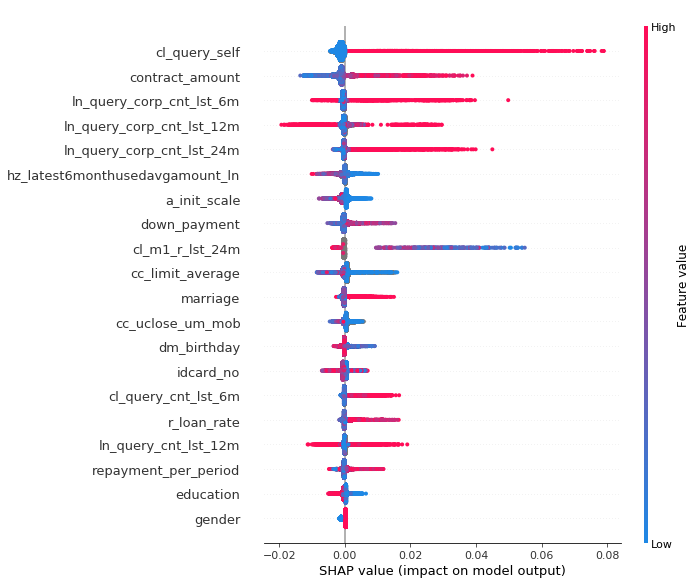

In [7]:
shap.summary_plot(shap_values, train[sel_cols])

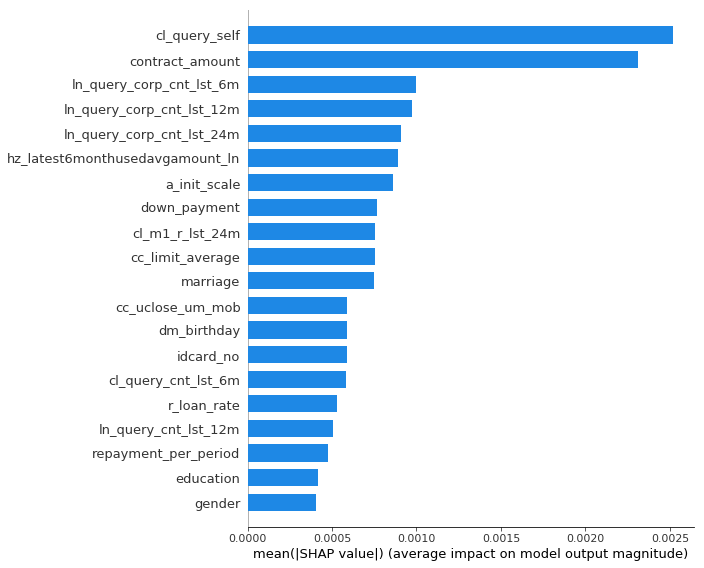

In [17]:
shap.summary_plot(shap_values, train[sel_cols], plot_type="bar")

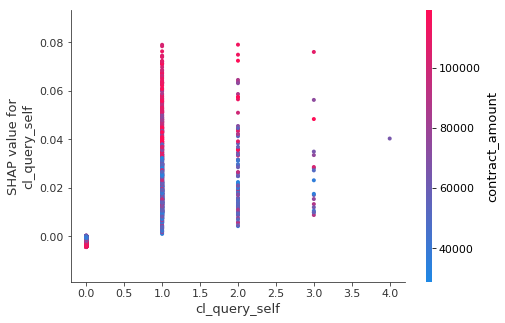

In [19]:
shap.dependence_plot("cl_query_self", shap_values, train[sel_cols])

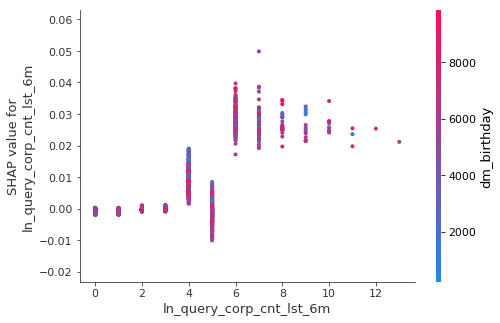

In [20]:
shap.dependence_plot("ln_query_corp_cnt_lst_6m", shap_values, train[sel_cols])